In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import os
import numpy as np
import cv2
%matplotlib inline

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/chest_xray/train/NORMAL')))
print(len(os.listdir('/content/drive/MyDrive/chest_xray/test/NORMAL')))
print(len(os.listdir('/content/drive/MyDrive/chest_xray/val/NORMAL')))
print(len(os.listdir('/content/drive/MyDrive/chest_xray/train/PNEUMONIA')))
print(len(os.listdir('/content/drive/MyDrive/chest_xray/test/PNEUMONIA')))
print(len(os.listdir('/content/drive/MyDrive/chest_xray/val/PNEUMONIA')))

1342
234
9
3900
390
9


In [ ]:

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Paths of datasets
train_path = "/content/drive/MyDrive/chest_xray/train"
val_path   = "/content/drive/MyDrive/chest_xray/val"
test_path  = "/content/drive/MyDrive/chest_xray/test"

# Parameters
img_size = 200
labels_map = {"NORMAL": 0, "PNEUMONIA": 1}  # Mapping folder names to labels

def load_images_from_folder(folder, img_size):
    X, y = [], []
    for label_name, label in labels_map.items():
        label_folder = os.path.join(folder, label_name)
        if not os.path.exists(label_folder):
            print(f"Warning: Folder not found -> {label_folder}")
            continue

        for img in os.listdir(label_folder):
            img_path = os.path.join(label_folder, img)
            try:
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Skipping unreadable image: {img_path}")
                    continue

                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                X.append(resized_arr)
                y.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    X, y = np.array(X, dtype=np.float32), np.array(y)
    return X, y

# Load data from all three folders
X_train, y_train = load_images_from_folder(train_path, img_size)
X_val, y_val     = load_images_from_folder(val_path, img_size)
X_test, y_test   = load_images_from_folder(test_path, img_size)

# Check if data loaded properly
print(f"Train images: {len(X_train)}, Val images: {len(X_val)}, Test images: {len(X_test)}")

# Combine all into single dataset
X = np.concatenate([X_train, X_val, X_test], axis=0)
y = np.concatenate([y_train, y_val, y_test], axis=0)

print("Combined dataset:", X.shape, y.shape)

# Normalize images and reshape for deep learning (add channel dimension)
X = X / 255.0
X = X.reshape(-1, img_size, img_size, 1)

# Split into Train + Test + Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32, stratify=y_train)

print("✅ Final splits:")
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Skipping unreadable image: /content/drive/MyDrive/chest_xray/train/NORMAL/.DS_Store
Skipping unreadable image: /content/drive/MyDrive/chest_xray/train/PNEUMONIA/.DS_Store
Skipping unreadable image: /content/drive/MyDrive/chest_xray/val/NORMAL/.DS_Store
Skipping unreadable image: /content/drive/MyDrive/chest_xray/val/PNEUMONIA/.DS_Store
Train images: 5240, Val images: 16, Test images: 624
Combined dataset: (5880, 200, 200) (5880,)
✅ Final splits:
Train: (3763, 200, 200, 1) (3763,)
Validation: (941, 200, 200, 1) (941,)
Test: (1176, 200, 200, 1) (1176,)


In [ ]:
# to balancing out disproportions in the dataset
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

In [ ]:
# Creating the Sequential model
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 256)  │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 200, 200, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 256)  │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 16)     │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800,141 (3.05 MB)

 Trainable params: 799,791 (3.05 MB)

 Non-trainable params: 350 (1.37 KB)

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=50)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


377/377 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - acc: 0.6881 - loss: 0.7020 - val_acc: 0.7311 - val_loss: 0.5637
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - acc: 0.7483 - loss: 0.5227 - val_acc: 0.8045 - val_loss: 0.4769
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - acc: 0.7751 - loss: 0.4647 - val_acc: 0.8512 - val_loss: 0.3853
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - acc: 0.7977 - loss: 0.4135 - val_acc: 0.5919 - val_loss: 0.6926
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - acc: 0.8236 - loss: 0.3797 - val_acc: 0.8629 - val_loss: 0.3042
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - acc: 0.8528 - loss: 0.3389 - val_acc: 0.8948 - val_loss: 0.2540
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - acc: 0.8575 - loss: 0.3396 - val_acc: 0.9033 - val_loss: 0.2334
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - acc: 0.8811 - loss: 0.2878 - val_acc: 0.9022 - val_loss: 0.2313
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/st

In [ ]:
model.evaluate(X_test, y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - acc: 0.9159 - loss: 0.2540


[0.21961858868598938, 0.9251700639724731]

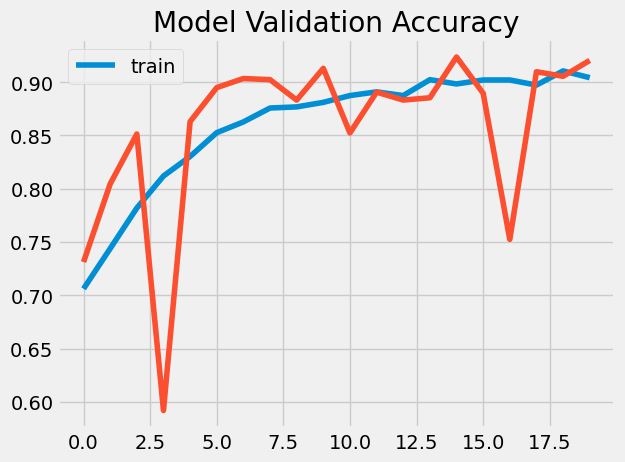

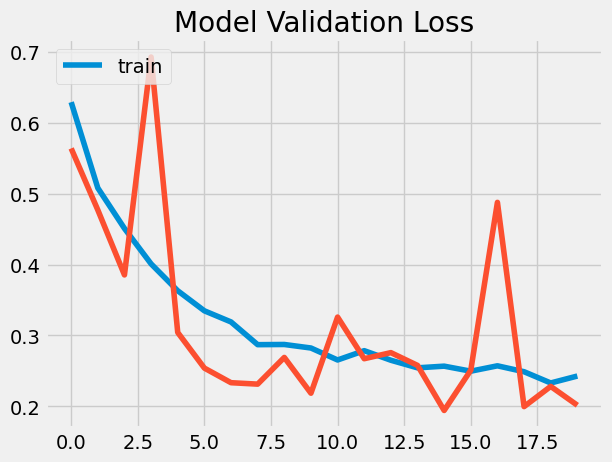

In [ ]:
# Plotting model accuracy and validation accuracy
plt.figure()
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

# Plotting model loss and validation loss
plt.figure()
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()


In [ ]:
# Predictions for test datasets
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

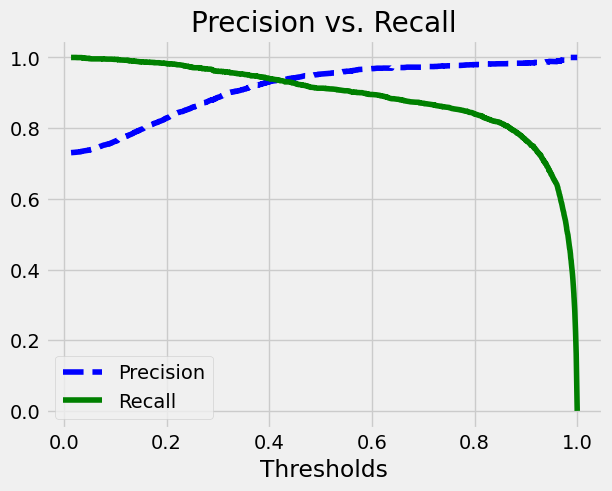

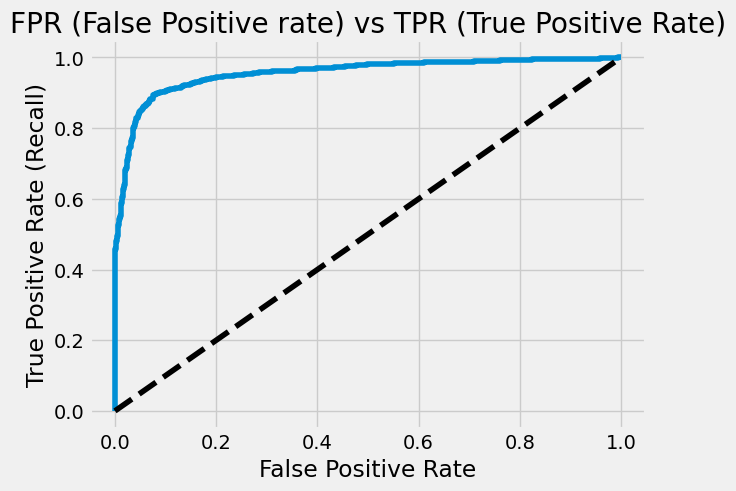

In [ ]:
# Plot for precision and recall
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

# Plot for true positive rate and false positive rate
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()

plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
# after Predictions we are using threshold to decide which class it belongs to
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [ ]:
# Accuracy, precision adn recall on testing data
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

In [ ]:
# Confusion matrix
labels = ['PNEUMONIA', 'NORMAL']
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt = '.0f', ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

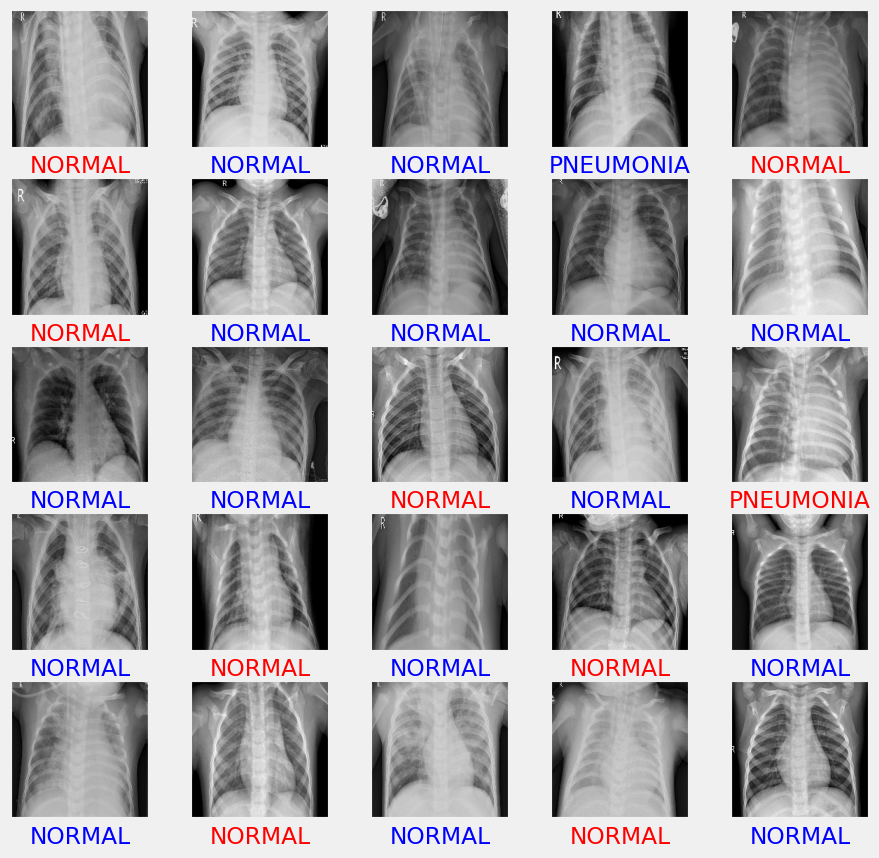

In [ ]:
# Visualizing the images with labels after predictions
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()